# IMAGE CLASSIFICATION PIPELINE W/ FastAI: Fashion MNIST

<b>The aim of this kernel:</b>
- Build a multi-class image classifier on the fashion MNIST dataset using a Convolutional Neural Network (CNN) based model.
- Make the library flexible enough to train an image classifieron a different dataset and be written in a way to allow anyone to use it.
- Accuracy at this stage is not the main goal.


# STEPS: 
1. Import appropriate modules
2. Data preparation
3. FastAI Data block API
4. Model training
5. Result interpretation
6. Finetuning
7. Data augmentation/ normalization 
8. Model inference/ prediction
    


### FastAI library can be used to solve different types of problems.: collab. filtering, vision, text, tabular. More info: [[docs.fast.ai]](https://docs.fast.ai/applications.html#data).<br/>In each case (except for collab filtering), the module is organized this way:

- **transform:**
  data pre-processing (data augmentation for images, cleaning for tabular data, tokenizing and numericalizing for text).

-  **data:**
   dataset class(es) definition to deal with this kind of data (images, text, table data, etc.)

-  **models:**
   specific models used for this kind of data (vision: resnet, densenet, vgg, alexnet, unet, Yolo; more info at [[docs.fast.ai]](https://docs.fast.ai/applications.html)

-  **learner:**
   contains functions that will directly bind this data with a suitable model and add the necessary callbacks.
   
Source: [[docs./fast/ai/applications]](https://docs.fast.ai/applications.html#data)


# 0. THEORY

    
    
### An algorithm to perform machine learning experiment:
    1. preprocess data
    2. split the data to training/validation/test sets
    3. build an initial system
    4. use bias/variance analysis and error analysis to tune the system

### The priority of different hyperparameters to tune
    - First important: learning rate
    - Second important: mini-batch size
    - Third important: number of layers, learning rate decay
    - Rarely tuned: hyperparameters of Adam optimization ( beta 1, beta 2, epsilon)

### Mini-batch size experimentation
    The advantage of using mini-batch gradient descent is in speed performance, although it adds
    some noise. How to choose batch size:
    
    - Mini-batch should fit in CPU/GPU memory – depends on the dataset and memory capacity.
    - For a small training set (N<2000) is better to use batch gradient descent (the whole dataset).
    - Typical mini-batch sizes: 64,128,256,512 etc.
    
### A training pipeline algorithm for bias/variance analysis:

    1. Check if the algorithm has a high bias (training dataset performance):
        - try the network with more hidden layers or hidden units (almost always helps)
        - try a higher number of epochs (more extended training, does not always help but almost never hurts)
        - try different NN architecture
        - change optimization algorithm (RMSProp, Momentum, Adam optimizer)
    2. Repeat the steps until bias is reduced to an acceptable amount.
    3. Check if the algorithm has a high variance (validation set performance):
        - get more data
        - data augmentation
        - try regularization
        - try another architecture
        - tune hyperparameters
    4. Training a bigger network almost never hurts. The downside is computational time.
    5. Make sure that the test set performs well on the cost function:
        - Bigger validation set
    6. Make sure that it works in the real-world application:
        - Distribution mismatch
        - Change validation set
        - Change cost functions.


# 1. IMPORT MODULES

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from fastai.vision import *
from PIL import Image
import os

torch.cuda.get_device_name(0)

# PyTorch works best as a low-level foundation library, providing the basic operations for higher level functionality. 
# The fastai library is the most popular library for adding this higher-level functionality on top of PyTorch. 


'Tesla P100-PCIE-16GB'

# 2. DATA PREPARATION

In [7]:
# Fashion MNIST dataset is stored in .csv files. Let's read them as a pandas table:

path = '/kaggle/input'
mnist_train = pd.read_csv(path+'/fashionmnist/fashion-mnist_train.csv')
mnist_test = pd.read_csv(path+'/fashionmnist/fashion-mnist_test.csv')

# mnist_train's head:
mnist_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
mkdir'/kaggle/working/train'

mkdir: cannot create directory ‘/kaggle/working/train’: File exists


In [9]:
mkdir'/kaggle/working/test'

mkdir: cannot create directory ‘/kaggle/working/test’: File exists


In [10]:
# result = Image.fromarray(np.uint8(np.stack(mnist_test.iloc[0,1:].to_numpy().reshape((28,28))*3,axis=-1))) 
# result.save('../kaggle/working/train/'+str(0)+'.png')

In [11]:
# we need to convert pixel values and store it as images to be able to benefit from fastai library ImageDataBunch loader. So, here's the function:
# if your dataset is stored as images, you can skip this step. If not,you can modify this function.

def csv2img(csv,path='/kaggle/working/train/'): 
    """
    Convert pixel values from .csv to .png image
    """
    for i in range(len(csv)):
        # csv.iloc[i,1:].to_numpy() returns pixel values array for i'th imag excluding the label 
        # next step: reshape the array to original shape(28,28) and add missing color channels 
        result = Image.fromarray(np.uint8(np.stack(np.rot90(csv.iloc[i,1:].to_numpy().reshape((28,28)))*3,axis=-1))) 
        # save the image:
        result.save(f'{path}{str(i)}.png')
        
    print(f'{len(csv)} images were created.')

# let's run the fuction:
csv2img(mnist_train)
csv2img(mnist_test,path='/kaggle/working/test/')

60000 images were created.
10000 images were created.


In [12]:
# check if the num of images in df and in the folder match: 
len(os.listdir('/kaggle/working/train')) == len(mnist_train)

True

In [13]:
# let's add text labels to the pandas table, we will use them for model training. 

dict_fashion = {
0:'T-shirt/top',
1:'Trouser',
2:'Pullover',
3:'Dress',
4:'Coat',
5:'Sandal',
6:'Shirt',
7:'Sneaker',
8:'Bag',
9:'Ankle boot'}

mnist_train['label_text'] = mnist_train['label'].apply(lambda x: dict_fashion[x])
mnist_test['label_text'] = mnist_test['label'].apply(lambda x: dict_fashion[x])

# add image names:
mnist_train['img'] = pd.Series([str(i)+'.png' for i in range(len(mnist_train))])
mnist_test['img'] = pd.Series([str(i)+'.png' for i in range(len(mnist_test))])


In [14]:
# save corresponding labels and image names to .csv file:
mnist_train[['img','label_text']].to_csv('/kaggle/working/labels.csv',index=False)
mnist_test[['img','label_text']].to_csv('/kaggle/working/test.csv',index=False)


# 3. FastAI Data block API

### The data block API lets you customize the creation of a DataBunch by isolating the underlying parts of that process in separate blocks, mainly:

- Where are the inputs and how to create them?
- How to split the data into a training and validation sets?
- How to label the inputs?
- What transforms to apply?
- How to add a test set?
- How to wrap in dataloaders and create the DataBunch?

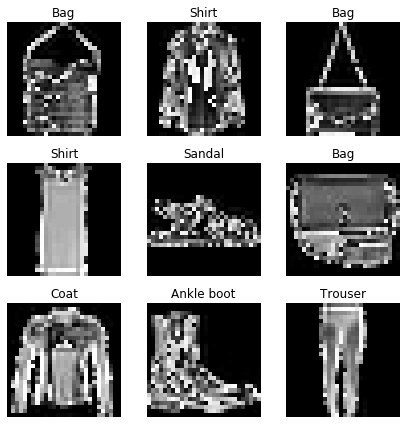

In [15]:
# Here, we load our images using the information stored in 'labels.csv': 'img' column includes image names; 'label_text' column includes lables.
# There are different ways to load the data into fastai's Data Block API, for more details please see the link: https://docs.fast.ai/data_block.html

data = (ImageList.from_csv('/kaggle/working/', 'labels.csv', folder='train')
        #Where to find the data? -> in '/kaggle/working/train' folder
        .split_by_rand_pct(seed=12)
        #How to split in train/valid? -> randomly with the default 20% in valid. There's an option to split by folfder or by id
        .label_from_df()
        #How to label? -> use the second column of the csv file and split the tags by ' '. / can be labeled by subfolder name/ can be labeled by applying regex to image name
        #.transform(tfms)
        #Data augmentation? -> use tfms with a size of 28. 
        .databunch() # change batch size and number of workers by passing arguments: (bs=32, num_workers=4, collate_fn=bb_pad_collate)
        #Finally -> use the defaults for conversion to databunch
        #.normalize()
       )   
        # Normalize x with mean and std, If you're using a pretrained model, you'll need to use the normalization that was used to train the model (e.g., imagenet_stats)

# Show image batch:
data.show_batch(rows=3, figsize=(6,6))


#################################
# one image:
# img,label = data.train_ds[5365]
# img
# define ImageDataBunch: 
# data = ImageDataBunch.from_df(path = '/kaggle/working/train/',df = mnist_train[['img','label_text']], seed = 12)

# 4. MODEL TRAINING


- The main purpose of Learner is to train model using Learner.fit. 
- After every epoch, all metrics will be printed and also made available to callbacks.
- Trainer for model using data to minimize loss_func with optimizer opt_func.

### <b>"fit one cycle" approach:</b>
    1. We progressively increase our learning rate from lr_max/div_factor to lr_max and at the same time we progressively decrease our momentum from mom_max to mom_min.
    2. We do the exact opposite: we progressively decrease our learning rate from lr_max to lr_max/div_factor and at the same time we progressively increase our momentum from mom_min to mom_max.
    3. We further decrease our learning rate from lr_max/div_factor to lr_max/(div_factor x 100) and we keep momentum steady at mom_max.

    Source: https://docs.fast.ai/callbacks.one_cycle.html#What-is-1cycle?
    paper: https://arxiv.org/pdf/1803.09820.pdf 


In [16]:
#  cnn_learner helps to automatically get a pretrained model from a given architecture with a custom head that is suitable for our data.

learn = cnn_learner(data, models.resnet34, metrics=[accuracy])

# available metrics: error_rate,accuracy, and others: https://docs.fast.ai/metrics.html

# available model architectures: https://docs.fast.ai/vision.models.html
# pretrained weights: True by default
# last layer removed and replaced new layer(head) with randomized weights, of an appropriate size for the dataset.


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [17]:
# Initial training:

learn.fit_one_cycle(4)


# What is fit one cycle approach? 
# shortly: this way of training the network reduces the training time and improves performance.


epoch,train_loss,valid_loss,accuracy,time
0,0.981349,0.817794,0.698500,00:39
1,0.717499,0.596714,0.771917,00:37
2,0.581892,0.515271,0.802250,00:35
3,0.547200,0.500934,0.806583,00:37


# 5. INTERPRETATION OF RESULTS

In [18]:
def interpret_res(plot_top_losses=True, conf_matrix=True, most_confused=False):
    """
    Result interpretation includes top losses, confusion matrix, and most confused.
    """
    
    # plot top losses:
    if plot_top_losses==True:
        interp = ClassificationInterpretation.from_learner(learn)
        losses,idxs = interp.top_losses()
        len(data.valid_ds)==len(losses)==len(idxs)
        interp.plot_top_losses(9, figsize=(12,12))

    # plot confusion matrix:
    if conf_matrix==True:
        doc(interp.plot_top_losses)
        interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

    # most confused:
    if most_confused==True:
        interp.most_confused(min_val=100)

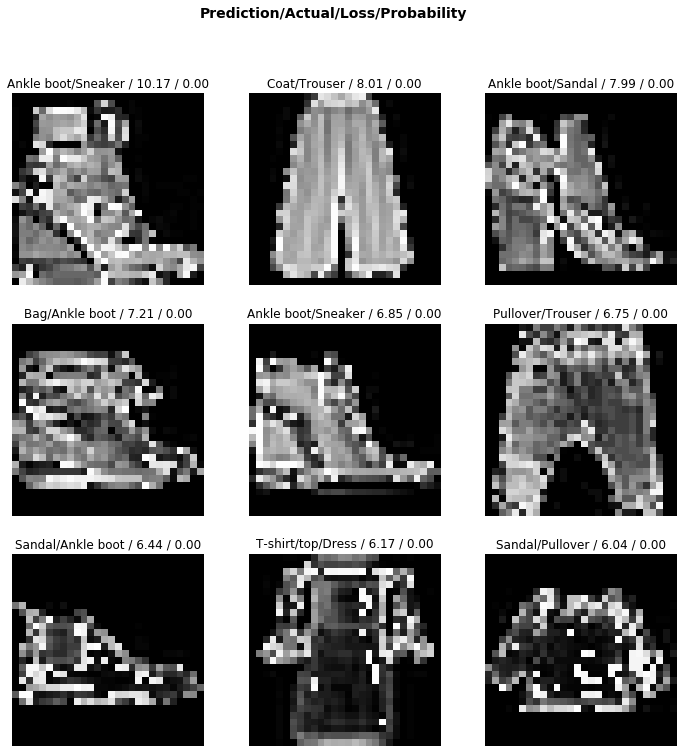

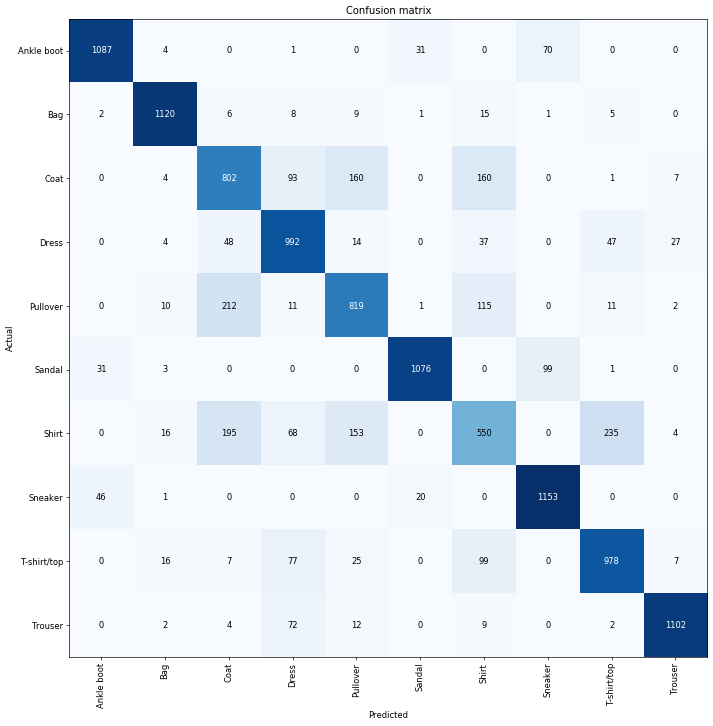

In [19]:
# we can see that it's not obvious even for human to classify the image properly:

interpret_res()

# 6. FINETUNING

1. Find appropriate learning rate
2. Unfreeze pre-trained weights
3. Bias/variance analysis - repeat until sutisfied 

### <b>Learning rate finder lr_find():</b>
    - Lets find the optimum learning rate for our comparison by doing an LR range test.
    - Learning rate finder: plots lr vs loss relationship to reduce the amount of guesswork on picking a good starting learning rate.
    - paper: https://arxiv.org/abs/1506.01186



epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


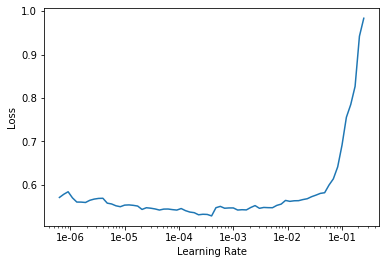

In [20]:
# we are looking for the sharpest downward slope range:
learn.lr_find()
learn.recorder.plot()

In [21]:
# unfreeze pre-trained weights and choose LR from previous step:

learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.403232,0.368903,0.865000,00:42
1,0.301374,0.302539,0.886333,00:40


In [22]:
# to save the model:
learn.save('resnet-temp')
# to load the model:
# learn.load('resnet-temp');

In [23]:
# Let's try another architecture with bigger number of parameters - ResNet50:

learn_resnet50 = cnn_learner(data, models.resnet50, metrics=[error_rate,accuracy])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


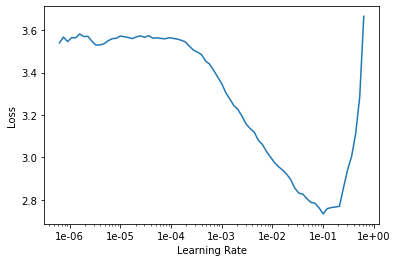

In [24]:
learn_resnet50.lr_find()
learn_resnet50.recorder.plot()

In [25]:
learn_resnet50.fit_one_cycle(4,max_lr=slice(1e-4,1e-2))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.908186,0.734942,0.257583,0.742417,00:45
1,0.586628,0.523554,0.198833,0.801167,00:44
2,0.479199,0.445562,0.168417,0.831583,00:45
3,0.434304,0.418769,0.156833,0.843167,00:44


In [26]:
# let's save the weights. We can come back to this stage if during experimentation smth happens:
learn_resnet50.save('learn_resnet50')
# learn_resnet50.load('learn_resnet50');

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


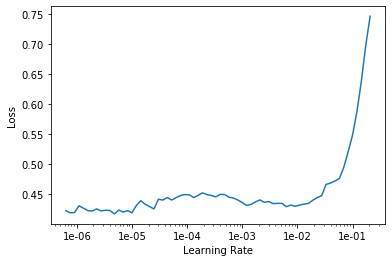

In [27]:
learn_resnet50.lr_find()
learn_resnet50.recorder.plot()

In [28]:
# unfreeze pre-trained weights:
# here, lr should be usually smaller than at the previous stage. Cuz we just need to fine-tune the weights, not to ruin them :)
# resnet50 has more weights and thus needs to be trained longer:

learn_resnet50.unfreeze()
learn_resnet50.fit_one_cycle(4, max_lr=1e-4)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.401686,0.357883,0.133250,0.866750,00:51
1,0.325476,0.317123,0.118167,0.881833,00:51
2,0.229804,0.276144,0.099917,0.900083,00:52
3,0.146879,0.286937,0.100583,0.899417,00:52


In [29]:
learn_resnet50.save('learn_resnet50_stage_2')

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


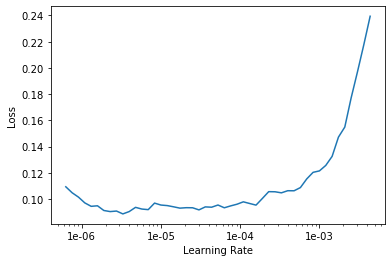

In [30]:
learn_resnet50.lr_find()
learn_resnet50.recorder.plot()

In [31]:
learn_resnet50.fit_one_cycle(4, max_lr=slice(1e-6,1e-5))
# model overfits the data (train loss goes down, valid loss is the same), accuracy drops:

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.113977,0.291879,0.099917,0.900083,00:52
1,0.109684,0.297403,0.101333,0.898667,00:52
2,0.106949,0.301921,0.100000,0.900000,00:52
3,0.099467,0.303819,0.102083,0.897917,00:52


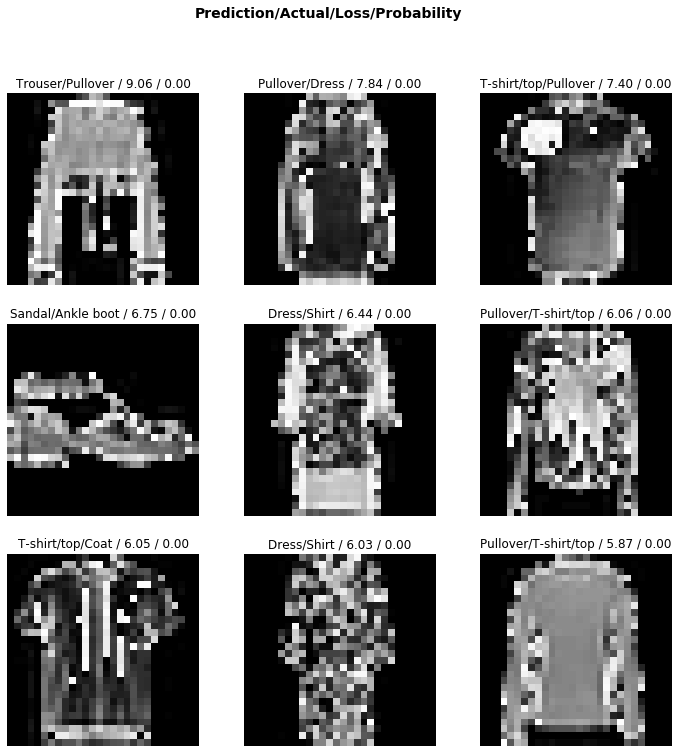

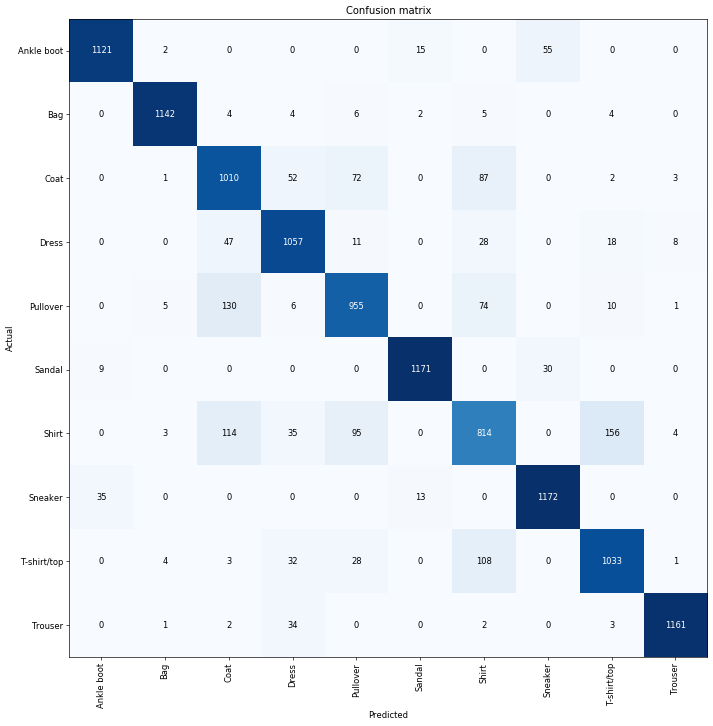

In [32]:
learn_resnet50.load('learn_resnet50_stage_2')
interpret_res()

# 7. DATA AUGMENTATION AND NORMALIZATION
#### **vision.transform** lets us do data augmentation: rotation, translation, zoom, crop, flip, and more.

In [33]:
help(get_transforms)

Help on function get_transforms in module fastai.vision.transform:

get_transforms(do_flip: bool = True, flip_vert: bool = False, max_rotate: float = 10.0, max_zoom: float = 1.1, max_lighting: float = 0.2, max_warp: float = 0.2, p_affine: float = 0.75, p_lighting: float = 0.75, xtra_tfms: Union[Collection[fastai.vision.image.Transform], NoneType] = None) -> Collection[fastai.vision.image.Transform]
    Utility func to easily create a list of flip, rotate, `zoom`, warp, lighting transforms.



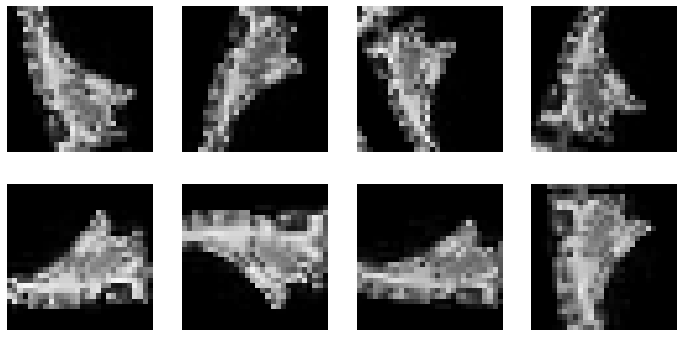

In [34]:
# Examples of image augmentaion:

tfms = get_transforms(do_flip=True,flip_vert=True,max_rotate=25)
def get_ex(): return open_image('/kaggle/working/train/1.png')

def plots_f(rows, cols, width, height, **kwargs):
    [get_ex().apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]
    
plots_f(2, 4, 12, 6, size=28)

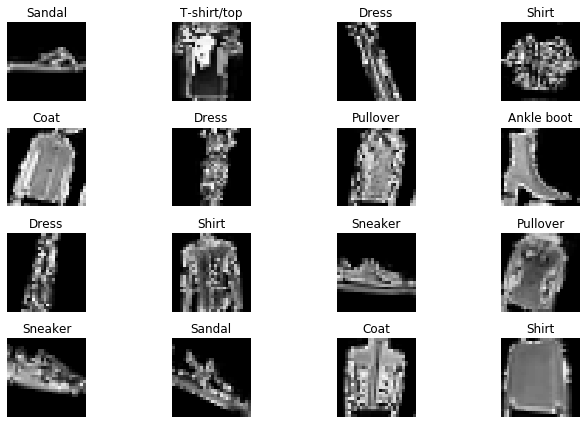

In [35]:
# define transforms:

tfms = get_transforms(do_flip=False,max_rotate=20)

# load data:
data = (ImageList.from_csv('/kaggle/working/', 'labels.csv', folder='train')
        .split_by_rand_pct(seed=12)
        .label_from_df()
        .transform(tfms)
        #Data augmentation? -> use tfms with a size of 28. Also, we can transform the image size adding another arg: (224,224)
        .databunch() 
        .normalize(imagenet_stats)
        # Normalize x with mean and std, If you're using a pretrained model, you'll need to use the normalization that was used to train the model (e.g., imagenet_stats)
       )   
        
    
data.show_batch(rows=4, figsize=(10,6))

In [36]:
# choose model:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate,accuracy])

In [37]:
# training head:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.180588,0.967479,0.365583,0.634417,01:28
1,0.849239,0.703524,0.272083,0.727917,01:29
2,0.705190,0.598872,0.231000,0.769000,01:27
3,0.700810,0.585626,0.223250,0.776750,01:29


epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


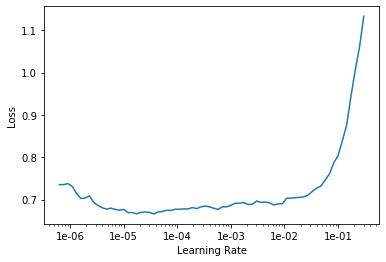

In [38]:
# choose suitable learning rate:
learn.lr_find()
learn.recorder.plot()

In [39]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.675543,0.580146,0.224333,0.775667,01:28
1,0.666604,0.572863,0.217583,0.782417,01:28


In [40]:
learn.save('test-21')

In [ ]:
learn.fit_one_cycle(4, max_lr=1e-4)

epoch,train_loss,valid_loss,error_rate,accuracy,time


In [ ]:
# unfreeze weights:

learn.unfreeze()
learn.fit_one_cycle(2, max_lr=1e-4)

# probably, we should change the augmentation method and/or try to train longer. Or choose higher lr

In [ ]:
# interpret results: 
interpret_res()

## 8. MODEL INFERENCE AND PREDICTION

- export model using Pickle (the standard way of serializing objects in Python) 
- load the model (all the settings saved)
- predict the image class

In [ ]:
# export .pkl file:
learn.export()
# load:
learn = load_learner('/kaggle/working')

## https://docs.fast.ai/tutorial.inference.html#Create-a-Learner-for-inference

In [ ]:
# run model inference on random image:

img = data.train_ds[0][0]
learn.predict(img)

# Out: a tuple of three things: 
#         - object predicted (with the class in this instance), 
#         - underlying data (here the corresponding index) 
#         - raw probabilities. 

# You can also do inference on a larger set of data by adding a test set. This is done by passing an ItemList to load_learner.

In [ ]:
# load inference model and test set:

learn = load_learner('/kaggle/working/', test=ImageList.from_folder('/kaggle/working/test'))

In [ ]:
# run predictions on test set:
preds,y = learn.get_preds(ds_type=DatasetType.Test)

# sort predictions by value, return the index (corresponds to the class):
preds[:5].argsort()

POSSIBLE IMPROVEMENTS:
    
    1. After fine-tuning stage, change the size of the input images and repeat head training and finetuning, and then again.
    2. memory purge # purge(clear_opt:bool=True)
    